# WPM algorithm in X frame for big masks

Propagation algorithms for wave optics usually allows masks with a small size, since the propagation step is around the wavelength. When big masks, with long propagation distances is required, the involved matrices are huge and cannot be properly stored. 

For this case, we have developed WPM function in X frame, where only a small quantity of data are stored:

- Field at the end of the simulation.
- Field at the focus, that is, at position z with the maximum concentration of intensity.
- Field at an  axis.
- Field at a z axis.
- Global XZ field, with reduced sampling.
- XZ field, in a small region of interest.

For this case, we have implemented WPM in X and XY schemes. The refractive index in the XZ or XYZ space is not stored in a matrix, but a function is required.

In [27]:
from diffractio import np, plt, sp, um, mm, degrees
from diffractio.scalar_fields_XZ import Scalar_field_XZ
from diffractio.scalar_masks_XZ import Scalar_mask_XZ

from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_X import Scalar_source_X


## X scheme

In [28]:
# Parameters

x = np.linspace(-3 * mm, 3 * mm, 1024 * 16)
z = np.linspace(-1 * mm, 21 * mm, 1024 * 8)
wavelength = 10 * um


In [29]:
dx = x[1] - x[0]
dz = z[1] - z[0]

print("x = {:2.5f}, z = {:2.2f}".format(dx, dz))
print("x/wavelength = {:2.5f}, z/wavelength = {:2.2f}".format(
    dx / wavelength, dz / wavelength))


x = 0.36623, z = 2.69
x/wavelength = 0.03662, z/wavelength = 0.27


In [30]:
u0 = Scalar_source_X(x, wavelength)
u0.plane_wave(A=1, theta=0.0, z0=0.0)


In [31]:
def fn(x, z, wavelength):
    """refractive index definition for a given example.

    Args:
        x (np.array): x positions
        z (np.array): z positions
        wavelength (float): wavelength

    Returns:
        (np.array): XZ array with refractive index
    """

    u = Scalar_mask_XZ(x, z, wavelength)
    u.sphere(r0=(0, 6 * mm), radius=6 * mm, refractive_index=1.32, angle=0)
    return np.squeeze(u.n)


In [32]:
# This would be the standard code, defining huge matrices for refractive index and u field.

if False:
    u_3d = Scalar_mask_XZ(x, z, wavelength)
    u_3d.n = fn(x, z, wavelength)
    u_3d.draw_refractive_index(scale='scaled')
    u_3d.incident_field(u0)
    u_3d.WPM(has_edges=False, matrix=False, verbose=True)
    u_3d.draw(logarithm=True, draw_borders=True, scale='scaled')


In [33]:
# Region of interest (ROI)

xout_roi = np.linspace(-500 * um, 500 * um, 256)
zout_roi = np.linspace(15 * mm, 21 * mm, 256)
ROI = (xout_roi, zout_roi)


In [34]:
# Execution

u_final_x, u_out_gv, u_out_roi, u_axis_x, u_axis_z, u_max, z_max = u0.WPM(
    fn,
    z,
    ROI=ROI,
    num_sampling=(1024, 1024),
    x_pos=0. * um,
    z_pos=12 * mm,
    get_u_max=True,
    has_edges=False,
    verbose=True)


Time = 39.93 s, time/loop = 4.874 ms


## Output data

Scalar_mask_XZ
 - x:  (1024,),   z:  (1024,),   u:  (1024, 1024)
 - xmin:       -3000.00 um,  xmax:      3000.00 um,  Dx:   5.87 um
 - zmin:       -1000.00 um,  zmax:      21000.00 um,  Dz:   21.51 um
 - Imin:       0.00,     Imax:      139.19
 - phase_min:  -180.00 deg, phase_max: 180.00 deg
 - wavelength: 10.00 um
 - date:       2022-11-20_18_17_26
 - info:       from WPM_no_storage_1D



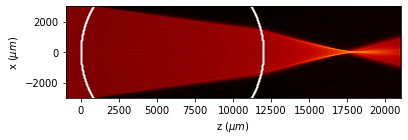

In [35]:
# Global region

print(u_out_gv)
u_out_gv.draw(logarithm=1e1, draw_borders=True, scale='scaled')


Scalar_mask_XZ
 - x:  (256,),   z:  (256,),   u:  (256, 256)
 - xmin:       -500.00 um,  xmax:      500.00 um,  Dx:   3.92 um
 - zmin:       15000.00 um,  zmax:      21000.00 um,  Dz:   23.53 um
 - Imin:       0.00,     Imax:      142.92
 - phase_min:  -179.99 deg, phase_max: 180.00 deg
 - wavelength: 10.00 um
 - date:       2022-11-20_18_17_27
 - info:       from WPM_no_storage_1D



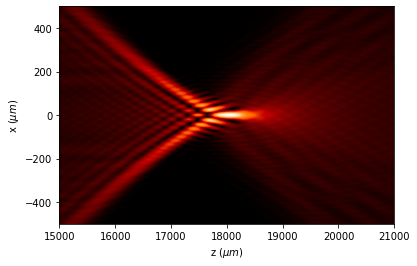

In [36]:
# Region of interest

print(u_out_roi)
u_out_roi.draw(logarithm=1e-1)


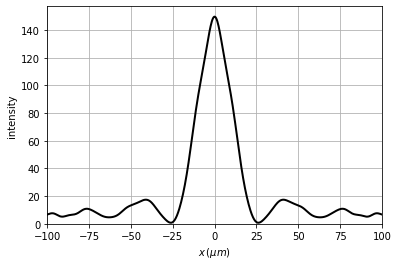

In [37]:
# Field at focus

u_max.draw()
plt.xlim(-10 * wavelength, 10 * wavelength)
plt.ylim(ymin=0)
plt.grid('on')


pos focus = 18.051 mm


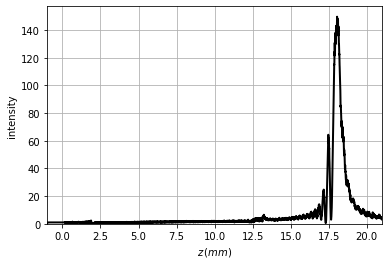

In [38]:
# Field at a x given axis

print("pos focus = {:2.3f} mm".format(z_max / mm))

u_axis_x.draw(z_scale='mm')

plt.ylim(ymin=0)
plt.xlim(z[0] / mm, z[-1] / mm)
plt.grid('on')

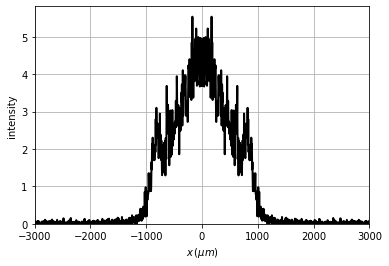

In [39]:
# Final field

u_final_x.draw()
plt.ylim(ymin=0)
plt.grid('on')


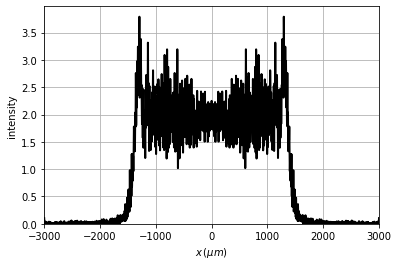

In [40]:
# Field at a z distance

u_axis_z.draw()
plt.grid('on')


## XZ Scheme

In [41]:
from diffractio import np, plt, sp, um, mm, degrees
from diffractio.scalar_fields_XYZ import Scalar_field_XYZ

from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.scalar_masks_XYZ import Scalar_mask_XYZ


In [42]:
# Parameters

num_z = 256
x = np.linspace(-50 * um, 50 * um, 512)
y = np.linspace(-50 * um, 50 * um, 512)
z = np.linspace(-10, 150 * um, num_z)
wavelength = 2 * um

dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

print("x = {:2.5f}, x = {:2.5f}, z = {:2.2f}".format(dx, dy, dz))
print("x/l = {:2.2f}, y/l = {:2.2f}, z/l = {:2.2f}".format(
    dx / wavelength, dy / wavelength, dz / wavelength))


x = 0.19569, x = 0.19569, z = 0.63
x/l = 0.10, y/l = 0.10, z/l = 0.31


In [43]:
u0 = Scalar_source_XY(x, y, wavelength)
u0.plane_wave(A=1)


In [44]:
def fn(x, y, z, wavelegth):
    u = Scalar_mask_XYZ(x, y, z, wavelength)
    u.sphere(r0=(0, 0, 50),
             radius=40 * um,
             refractive_index=1.33,
             angles=(0, 0, 0))
    index = u.n
    del u
    return np.squeeze(index)


In [45]:
xout_roi = np.linspace(-20 * um, 20 * um, 128)
yout_roi = np.linspace(-20 * um, 20 * um, 128)
zout_roi = np.linspace(90 * um, 140 * um, 64)
ROI = (xout_roi, yout_roi, zout_roi)

num_sampling = (128, 128, 64)


In [46]:
z_pos = 0.1 * mm


In [47]:
# Execution

u_final_x, u_out_gv, u_out_roi, u_axis_x, u_axis_z, u_max, z_max = u0.WPM(
    fn,
    zs=z,
    ROI=ROI,
    num_sampling=num_sampling,
    r_pos=(0. * um, 0. * um),
    z_pos=z_pos,
    get_u_max=True,
    has_edges=False,
    verbose=True)


Time = 25.73 s, time/loop = 100.5 ms


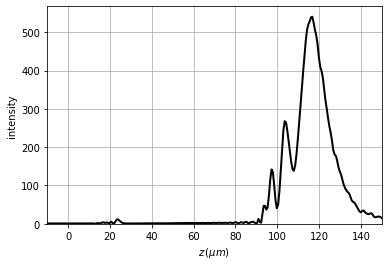

In [48]:
### Field at axis

u_axis_x.draw()
plt.grid('on')


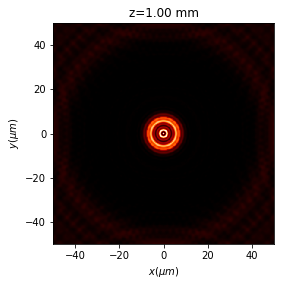

In [49]:
# Field at z distance

u_axis_z.draw(logarithm=1e-1)
plt.title("z={:2.2f} mm".format(z_pos / 100))


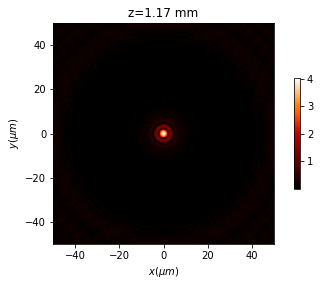

In [50]:
# Field at focus
u_max.draw(logarithm=1e-1, has_colorbar='vertical')
plt.title("z={:2.2f} mm".format(z_max / 100))


<Figure size 432x288 with 0 Axes>

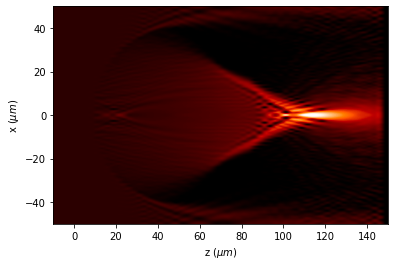

In [51]:
#Global view
uxz_gv = u_out_gv.draw_XZ(y0=0, logarithm=1e0)


<Figure size 432x288 with 0 Axes>

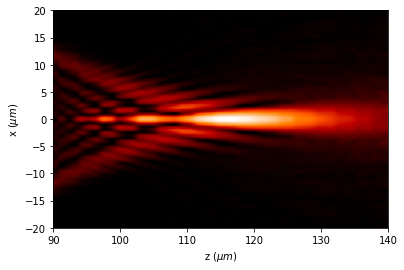

In [52]:
# Region of interest

u_out_roi.draw_XZ(logarithm=1e-1)
